# Workflows

For now we mainly looked at models in isolation. However, the true power of probabilistic modelling lies in its ability to move beyond the "one-model-fits-all" idea, but rather create a variety of models and connect or compare them in various ways. Indeed, even for a normal use cases, we already typically go up to a dozen models or more. In more complex experimental designs, which are becoming every more common, this can easily go up to a hundred or more.

In [1]:
%load_ext autoreload
%autoreload 2
import latenta as la
import lacell as lac
import numpy as np

Even in relatively simple use cases, managing different models, storing them across sessions, and let them depend on each other can be a pain. To make this easier, we created a small workflow manager in the _laflow_ package. It borrows elements from other workflow managers such as snakemake or nextflow. However, it is much more focused on interactivity, modularization and model inheritance, all concepts very central to the modelling we're doing here.

The core tasks of laflow is:
- **Persistence**, to store sure models and its derivatives on disk
- **Model inheritance**, creation of similar models that only differ in certain aspects
- **Connecting data**, to explicitely define what objects are needed to produce what

In [2]:
import laflow as laf

We'll use the same dataset as [before](./1-variables).

In [3]:
adata = la.data.load_myod1()

In [4]:
import scanpy as sc

adata.raw = adata

sc.pp.normalize_per_cell(adata)
sc.pp.log1p(adata)

sc.pp.combat(adata)
sc.pp.pca(adata)

sc.pp.neighbors(adata)
sc.tl.umap(adata)

adata.obs["log_overexpression"] = np.log1p(adata.obs["overexpression"])

/home/wsaelens/projects/probabilistic-cell/.venv/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'dissociation' as categorical


/home/wsaelens/projects/probabilistic-cell/.venv/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'gene_overexpressed' as categorical


/home/wsaelens/projects/probabilistic-cell/.venv/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'batch' as categorical


/home/wsaelens/projects/probabilistic-cell/.venv/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'biotype' as categorical


/home/wsaelens/projects/probabilistic-cell/.venv/lib/python3.8/site-packages/scanpy/preprocessing/_combat.py:340: RuntimeWarning: divide by zero encountered in true_divide
  (abs(g_new - g_old) / g_old).max(), (abs(d_new - d_old) / d_old).max()


## Persistence

The basis of _laflow_ is the {class}`~laflow.Flow` class. Each instance we create is associated with a particular folder on disk, starting from a given root directory. We work from a temporary directory in these tutorials, but in real life use cases this root is typically  your project's root directory or one of its subdirectories.

In [5]:
import tempfile
import pathlib

project_root = pathlib.Path(tempfile.TemporaryDirectory().name)
project_root.mkdir()
laf.set_project_root(project_root)  # sets the default project root

We can then create a {class}`~laflow.Flow` object as follows. Because we have set the default root for this python session, we don't have to provide this explicitely. All we need to provide is a name for the flow:

In [6]:
dataset = laf.Flow("dataset")
dataset.path  # the path associated with this flow

PosixPath('/tmp/tmplldaxr21/dataset')

This folder will store information on each object, links to other objects or flows, and the objects themselves if they are labeled as persistent. We can store a python object inside a flow by simply assigning it:

In [7]:
dataset.adata = adata

Because python objects are by default persistent, the `adata` object was saved in the folder as a pickle. Along with it is a info json file which is used internally to keep track which type of object it is and how it was created.

In [8]:
!ls -lh {dataset.path}

total 17M
-rw-r--r-- 1 wsaelens updepla 156 Nov  2 11:41 adata.info
-rw-r--r-- 1 wsaelens updepla 17M Nov  2 11:41 adata.pkl


When working in IPython environments (e.g. Jupyter), we can always check what contents a flow object has as follows:

In [9]:
dataset

Even if we restart our session (simulated here by removing the flow object), we can always retrieve it by recreating a flow object in the correct folder:

In [10]:
if "dataset" in globals():
    del dataset
dataset = laf.Flow("dataset")

In [11]:
dataset

We can also have persistence of other objects. If you provide a matplotlib object, this will be stored as a png and pdf:

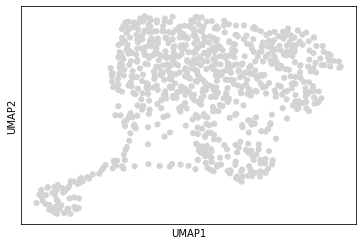

In [12]:
# don't forget the return_fig, or this function will return None and that will be stored as a pickle
dataset.basic_umap = sc.pl.umap(dataset.adata, return_fig=True)

In [13]:
dataset

In [14]:
!ls -lh {dataset.path}

total 18M
-rw-r--r-- 1 wsaelens updepla 156 Nov  2 11:41 adata.info
-rw-r--r-- 1 wsaelens updepla 17M Nov  2 11:41 adata.pkl
-rw-r--r-- 1 wsaelens updepla 165 Nov  2 11:41 basic_umap.info
-rw-r--r-- 1 wsaelens updepla 18K Nov  2 11:41 basic_umap.pdf
-rw-r--r-- 1 wsaelens updepla 30K Nov  2 11:41 basic_umap.png


## Connecting flows

To make our workflows more modular, we use Python's OOP system to systematically let certain flows depend on each other and share common code. For example, a dataset in our example would be defined as follows:

In [15]:
class Dataset(laf.Flow):
    default_name = "dataset"
    adata = laf.PyObj()

We can initialize this dataset as before. Note that we do not provide a name in this case as we want to use the default "dataset" name:

In [16]:
dataset = Dataset(adata=adata)

In [17]:
dataset

If we would then make a model, we could make it depend on the dataset as follows:

In [18]:
class Model(laf.Flow):
    default_name = "model"
    dataset = laf.FlowObj()

In [19]:
model = Model(dataset=dataset)

In [20]:
model

The dataset is now linked to the model, and we can access it as follows:

In [21]:
model.dataset

This can stack indefintely. On disk, the link to the dataset is stored as a symbolic link:

In [22]:
!ls -lhaG --color=always {model.path} | sed -re 's/^[^ ]* //'

16K
2 wsaelens 4.0K Nov  2 11:41 .
4 wsaelens 4.0K Nov  2 11:41 ..
1 wsaelens   24 Nov  2 11:41 dataset -> /tmp/tmplldaxr21/dataset
1 wsaelens   97 Nov  2 11:41 dataset.info
1 wsaelens   40 Nov  2 11:41 .flow


## Building workflows

We learned how to define and assign objects in a flow, but to create workflows we also need to define how those objects are created and how they depend on each other. We do this by defining functions inside the Flow class that are decorated by {class}`~laflow.Step`. This decorator allows you to specify where each input is coming from, and which outputs are produced by the step.

For example, to write a step that creates the initial model (before we inferred the parameters), we would do the following:

In [23]:
class LinearModel(laf.Flow):
    # sets the default name
    default_name = "linear"

    # lets the flow know that it can contain a link to another flow called dataset
    dataset = laf.FlowObj()

    # lets the flow know that it can expect a model_initial object, that is not persistent
    model_initial = laf.LatentaObj(persistent=False)

    # creates a particular step, that expects adata as input, and that outputs model_initial
    # note that our function not only expects "output" as an argument
    # this object should be used to store the outputs
    @laf.Step(laf.Inputs(adata=dataset.adata), laf.Outputs(model_initial))
    def create(self, output, adata):
        # define the model as before
        overexpression = la.Fixed(
            adata.obs["log_overexpression"], label="overexpression"
        )
        transcriptome = lac.transcriptome.TranscriptomeObservation.from_adata(adata)
        foldchange = transcriptome.find("foldchange")

        foldchange.overexpression = la.links.scalar.Constant(
            overexpression, definition=foldchange.value_definition
        )

        # apart from each input, the step function will also receive an output object
        # you should put any expected outputs in this object either by assigning it
        # or by using the update function
        return output.update(model_initial=transcriptome)

Apart from all inputs, your function will also receive a special `output` object in which you can store all the outputs that are produced. These will then be saved for you.

In [24]:
model = LinearModel(dataset=dataset)

In [25]:
model

In [26]:
model.create()

▶️ | linear/create                                                                                       


✅ | linear/create                                                                                       


In real use cases, we will typically store our workflows in a separate file so that they are easier to maintain. A full linear regression workflow, that includes inference and interpretation, is contained in the `basic_workflow.py` file:

In [27]:
basic_workflow_text = """
import laflow as laf
import latenta as la
import lacell as lac

class LinearModel(laf.Flow):
    # sets the default name
    default_name = "linear"

    # lets the flow know that it can contain a link to another flow called dataset
    dataset = laf.FlowObj()

    # lets the flow know that it can expect a model_initial object, that is not persistent
    model_initial = laf.LatentaObj(persistent=False)

    # creates a particular step, that expects adata as input, and that outputs model initial
    # note the way we access the adata from the dataset object
    @laf.Step(
        laf.Inputs(adata = dataset.adata),
        laf.Outputs(model_initial)
    )
    def create(self, output, adata):
        # define the model as before
        overexpression = la.Fixed(
            adata.obs["log_overexpression"], label="overexpression"
        )
        transcriptome = lac.transcriptome.TranscriptomeObservation.from_adata(adata)
        foldchange = transcriptome.find("foldchange")

        foldchange.overexpression = la.links.scalar.Linear(
            overexpression, a = True, definition=foldchange.value_definition
        )
        
        # apart from each input, the step function will also receive an output object
        # you should put any expected outputs in this object either by assigning it 
        # or by using the update function
        return output.update(model_initial = transcriptome)

    # the (final) model is persistent by default
    model = laf.LatentaObj()
    
    # another step, that receives the model_initial as input, and outputs the model
    @laf.Step(
        laf.Inputs(model_initial),
        laf.Outputs(model)
    )
    def infer(self, output, model_initial):
        # infer the model as before
        # we first clone the model_initial so that we do not overwrite it
        model = model_initial.clone()
        with model.switch(la.config.device):
            inference = la.infer.svi.SVI(
                model, [la.infer.loss.ELBO()], la.infer.optim.Adam(lr=5e-2)
            )
            trainer = la.infer.trainer.Trainer(inference)
            trace = trainer.train(10000)

        return output.update(model = model)

    # define our three posteriors, each one with a "db" argument
    # this will make sure that any model objects are not stored in the posterior,
    # but are rather extracted each time from the model object as defined earlier
    transcriptome_observed = laf.LatentaObj(db = {model})
    overexpression_observed = laf.LatentaObj(db = {model})
    overexpression_causal = laf.LatentaObj(db = {model})
    
    @laf.Step(
        laf.Inputs(model),
        laf.Outputs(transcriptome_observed, overexpression_observed, overexpression_causal)
    )
    def interpret(self, output, model):
        transcriptome_observed = la.posterior.vector.VectorObserved(model)
        transcriptome_observed.sample(5)
        output.transcriptome_observed = transcriptome_observed

        overexpression = model.find("overexpression")

        overexpression_observed = la.posterior.scalar.ScalarObserved(overexpression)
        overexpression_observed.sample(5)
        output.overexpression_observed = overexpression_observed

        overexpression_causal = la.posterior.scalar.ScalarVectorCausal(
            overexpression,
            model,
            interpretable=model.p.mu.expression,
            observed=overexpression_observed,
        )
        overexpression_causal.sample(10)
        overexpression_causal.sample_random(10)
        overexpression_causal.observed
        overexpression_causal.sample_empirical()
        output.overexpression_causal = overexpression_causal
        
        return output
"""
with open("./basic_workflow.py", "w") as f:
    f.write(basic_workflow_text)

In [28]:
text = open("./basic_workflow.py").read()
from myst_nb import glue
from IPython import display

glue(
    "basic_workflow_1", display.Markdown("```python\n" + text + "\n```"), display=False
)

::::{dropdown} 📃 basic_workflow.py (1)
:::{glue:} basic_workflow_1
:::
::::

Because this is a `.py` file, we can import it as a python module as follows:

In [29]:
import basic_workflow

In [30]:
model = basic_workflow.LinearModel()
model

In [31]:
model.infer()

▶️ | linear/create                                                                                       


✅ | linear/create                                                                                       


▶️ | linear/infer                                                                                        


  0%|                                                                                                         …

✅ | linear/infer                                                                                        


In [32]:
model.interpret()

▶️ | linear/interpret                                                                                    


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

✅ | linear/interpret                                                                                    


In [33]:
model

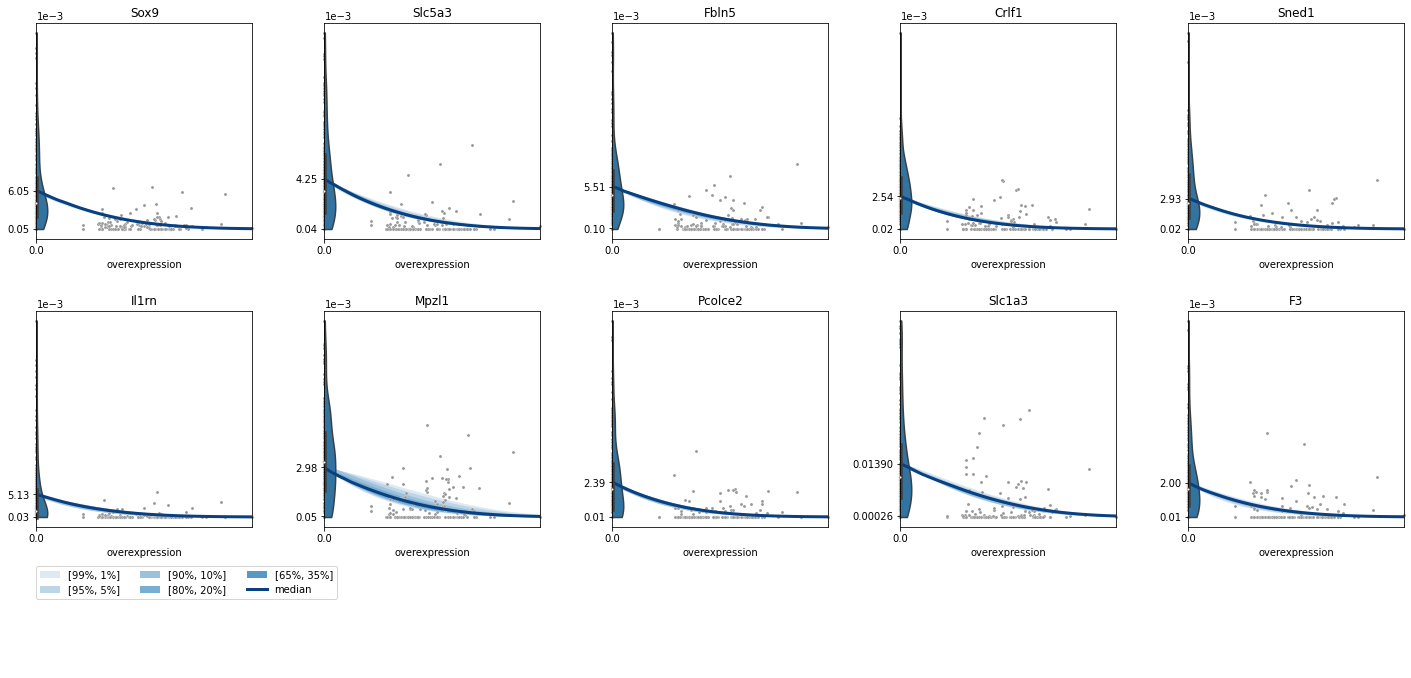

In [34]:
model.overexpression_causal.plot_features()

## Sharing and inheriting workflow steps

We defined a basic linear model, but what we actually want is to create many different models and infer/interpret them in the same way. We do this using inheritance: we first create the linear model by using `super().create_`, and then make the desired adaptations to the model:

In [35]:
extended_workflow_text = """
class ConstantModel(LinearModel):
    # we change the default name, as to make sure this model is put in a different folder
    default_name = "constant"

    def create(self, output, adata):
        # we can access the parent function by adding a "_" at the end
        # without this, we would call the actual step itself, and not the user-defined function
        output = super().create_(output = output, adata = adata)
        
        # extract the model_initial from the output
        model_initial = output.model_initial
        
        # now we can further adapt the model to our wishes
        foldchange = model_initial.find("foldchange")
        overexpression = model_initial.find("overexpression")

        foldchange.overexpression = la.links.scalar.Constant(
            overexpression, definition=foldchange.value_definition
        )
        
        # again return the output
        # because we only adapted the model inplace, we do not need to update the output
        return output


class SplineModel(LinearModel):
    default_name = "spline"

    def create(self, output, adata):
        output = super().create_(output = output, adata = adata)
        
        model_initial = output.model_initial

        foldchange = model_initial.find("foldchange")
        overexpression = model_initial.find("overexpression")

        foldchange.overexpression = la.links.scalar.Spline(
            overexpression, definition=foldchange.value_definition
        )

        return output
"""
with open("./basic_workflow.py", "a") as f:
    f.write(extended_workflow_text)

In [36]:
# glue the
text = extended_workflow_text
glue(
    "basic_workflow_2", display.Markdown("```python\n" + text + "\n```"), display=False
)

::::{dropdown} 📃 basic_workflow.py (2)
:::{glue:} basic_workflow_2
:::
::::

In [37]:
model = basic_workflow.ConstantModel(dataset=dataset)
model.create()
model.infer()
model.interpret()

▶️ | constant/create                                                                                     


✅ | constant/create                                                                                     


▶️ | constant/infer                                                                                      


  0%|                                                                                                         …

✅ | constant/infer                                                                                      


▶️ | constant/interpret                                                                                  


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

✅ | constant/interpret                                                                                  


In [38]:
model = basic_workflow.SplineModel(dataset=dataset)
model.create()
model.infer()
model.interpret()

▶️ | spline/create                                                                                       


✅ | spline/create                                                                                       


▶️ | spline/infer                                                                                        


  0%|                                                                                                         …

✅ | spline/infer                                                                                        


▶️ | spline/interpret                                                                                    


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

✅ | spline/interpret                                                                                    


:::{seealso}
_lacell_ contains different pre-built workflows for particular use cases. For example, {class}`~lacell.transcriptome.TranscriptomeDataset` and {class}`~lacell.transcriptome.TranscriptomeModel` already contain a blueprint on how to efficiently store and infer transcriptomics models. See "[](/guide/transcriptomics/transcriptome_model)" for an explanation.
:::
